In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
np.random.seed(42)

## Modell:
$\sin(Ax)=y$ mit $A$ $m\times n$-Matrix, $m$, $n$ beliebig ($A$ also insbesondere nicht zwingend quadratisch)

$x$ wird gesucht.

In [3]:
A = np.random.random(size = (100, 100))
x = np.random.random(size = (100, ))

In [4]:
y = np.sin(np.dot(A, x))

$A$ ist invertierbar:

In [5]:
if A.shape[0] == A.shape[1]:
    print(np.linalg.inv(A))

[[ 0.58611217  0.22754722  0.22079958 ... -0.35934623  0.66178901
   0.19085717]
 [-0.86053578  0.35823913 -0.05086583 ... -0.28753986  0.01246512
  -1.48921599]
 [ 0.26764428 -0.13717687 -0.92694754 ...  0.09591585 -1.22390556
   2.1684163 ]
 ...
 [ 0.66359634 -0.39434052  0.53305901 ...  0.12365094  0.66198343
   0.04954313]
 [-0.06110287  0.01871632 -0.28590078 ...  0.03731371 -0.48258655
   0.91014539]
 [-1.43651032  0.47662975 -0.21419412 ... -0.01676364  0.36827009
  -2.7539353 ]]


Verlustfunktion: mittlerer quadratischer Fehler $\frac{1}{n}\Vert y - \hat{y}\Vert^2$

In [6]:
from sklearn.metrics import mean_squared_error

Ableitung der Verlustfunktion nach den predictions $\hat{y}$ ist für ein $\hat{y}_i$: 

$-\frac{2}{n}(y_i-\hat{y}_i)$

In [7]:
def grad_loss(y_true, y_pred):
    return (-2) / y_true.shape[0] * (y_true - y_pred)

Loss, wenn der Mittelwert aller $y_i$ stets als prediction verwendet wird:

In [8]:
mean_squared_error(y, np.ones(y.shape[0])*np.mean(y))

0.5114195407413349

## EnKF-Algorithmus, wie ich ihn auch sonst implementiert habe

In [9]:
iterations = 100
particles = 100
randomization = True

In [10]:
h_0 = 2
epsilon = 0.5

In [11]:
# Dictionary, in das die Partikel (Vektoren, Schätzungen für x) geschrieben werden
param_dict = {}
# Dictionary, in das für alle Partikel die predictions für y geschrieben werden
y_pred_dict = {}
# Dictionary, in das für alle Partikel die Ableitungen der Verlustfunktion nach den predictions geschrieben werden
jacobian_dict = {}
# Dictionary, das für alle Partikel die Werte der Verlustfunktion enthält
loss_dict = {}

Initialisierung durch eine Normalverteilung und erste Auswertung:

In [12]:
for i in range(particles):
    param_dict["particle_{}".format(i+1)] = np.random.normal(loc = 0, scale = 1, size = x.shape)
    y_pred_dict["particle_{}".format(i+1)] = np.sin(np.dot(A, param_dict["particle_{}".format(i+1)]))
    jacobian_dict["particle_{}".format(i+1)] = grad_loss(y, y_pred_dict["particle_{}".format(i+1)])
    loss_dict["particle_{}".format(i+1)] = mean_squared_error(y, y_pred_dict["particle_{}".format(i+1)])

Mittelwerte aller Parameter der Partikel für die endgültige Schätzung von x:

In [13]:
param_mean = np.mean(list(param_dict.values()), axis = 0)

Loss für die gemittelten Parameter fortlaufend notieren:

In [14]:
loss_evolution = []
loss_evolution.append(mean_squared_error(y, np.sin(np.dot(A, param_mean))))

In [15]:
# zum Testen der einzelnen Partikel
loss_evolution_single_dict = {}
for i in range(particles):
    loss_evolution_single_dict["particle_{}".format(i+1)] = [mean_squared_error(y, np.sin(np.dot(A, param_dict["particle_{}".format(i+1)])))]

### EnKF

In [16]:
for iteration in range(iterations):
    
    # update the predictions, jacobian and loss for the new parameters
    for i in range(particles):
        y_pred_dict["particle_{}".format(i+1)] = np.sin(np.dot(A, param_dict["particle_{}".format(i+1)]))
        jacobian_dict["particle_{}".format(i+1)] = grad_loss(y, y_pred_dict["particle_{}".format(i+1)])
        loss_dict["particle_{}".format(i+1)] = mean_squared_error(y, y_pred_dict["particle_{}".format(i+1)])
    
    # compute the mean of the predictions
    y_pred_mean = np.mean(list(y_pred_dict.values()), axis = 0)
    
    # compute the matrix D elementwise
    d = np.zeros(shape = (particles, particles))
    for k in range(particles):
        y_pred_centered = y_pred_dict["particle_{}".format(str(k+1))] - y_pred_mean
        for j in range(particles):
            d[k][j] = np.dot(y_pred_centered, jacobian_dict["particle_{}".format(str(j+1))])
           
    # compute the scalar h_t
    h_t = h_0 / (np.sqrt(np.sum(d**2)) + epsilon)
        
    # matrix with particle parameters as row vectors
    params_all_ptcls = np.array(list(param_dict.values()))
    
    # compute the matrix with the updates for each particle
    params_all_ptcls = params_all_ptcls - h_t * np.dot(d, params_all_ptcls)
    
    # write the updates back into the dictionary
    for i in range(particles):
        param_dict["particle_{}".format(str(i+1))] = params_all_ptcls[i]
        if randomization:
            # add randomization/ noise to each particle
            stddev = 0.1
            noise = np.random.normal(loc = 0.0,
                                     scale = stddev,
                                     size = param_dict["particle_{}".format(str(i+1))].shape)
            new_param = param_dict["particle_{}".format(str(i+1))] + noise
            param_dict["particle_{}".format(str(i+1))] = new_param
    if randomization:
        # randomize particles around their mean
        param_dict_mean = list(np.mean(list(param_dict.values()), axis = 0))
        for i in range(particles):
            stddev = 0.1
            noise = np.random.normal(loc = 0.0,
                                     scale = stddev,
                                     size = param_dict["particle_{}".format(str(i+1))].shape)
            new_params = param_dict_mean + noise
            param_dict["particle_{}".format(str(i+1))] = new_params
    
    # compute loss for the parameter means
    param_mean = np.mean(params_all_ptcls, axis = 0)
    loss_evolution.append(mean_squared_error(y, np.sin(np.dot(A, param_mean))))
    
    # zum Testen der einzelnen Partikel
    for i in range(particles):
        loss_evolution_single_dict["particle_{}".format(i+1)].append(mean_squared_error(y, np.sin(np.dot(A, param_dict["particle_{}".format(i+1)]))))

Mit Randomization: Loss schwankt ungleichmäßig.

Ohne Randomization: Loss bleibt gleich ?!

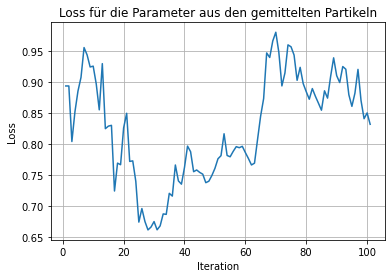

In [17]:
plt.plot(np.arange(len(loss_evolution))+1, loss_evolution)
plt.grid()
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Loss für die Parameter aus den gemittelten Partikeln")
plt.show()

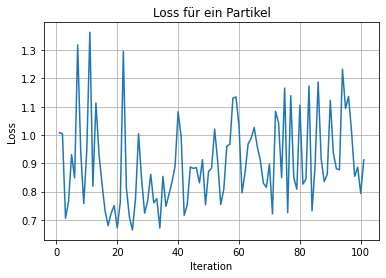

In [18]:
plt.plot(np.arange(len(loss_evolution_single_dict["particle_1"]))+1, loss_evolution_single_dict["particle_1"])
plt.grid()
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Loss für ein Partikel")
plt.show()

## EnKF wie für inverse Probleme

In [19]:
noise = False
y = np.sin(np.dot(A, x))
stddev_noise = np.ones(shape = y.shape)
if noise:
    noises = np.random.normal(loc = 0, scale = stddev_noise, size = y.shape)
    y = y + noises
    gamma = np.diag(stddev_noise**2)

In [20]:
batch = True
if batch:
    epochs = 10
    batch_size = int(np.floor(y.shape[0] / 10))         
else:
    epochs = 100
    batch_size = y.shape[0]

In [21]:
particles = 500
epochs = 200
batch_size = 10

In [22]:
n = y.shape[0]
num_batches = int(np.ceil(n / batch_size))
batch_indices = np.cumsum([0] + list(np.ones(num_batches) * batch_size))
batch_indices[-1] = n

In [23]:
# Dictionary, in das die Partikel (Vektoren, Schätzungen für x) geschrieben werden
param_dict = {}
# Dictionary, in das für alle Partikel die predictions für y geschrieben werden
y_pred_dict = {}
# Dictionary, das für alle Partikel die Werte der Verlustfunktion enthält
loss_dict = {}

In [24]:
for i in range(particles):
    param_dict["particle_{}".format(i+1)] = np.random.normal(loc = 0, scale = 1, size = x.shape)
    y_pred_dict["particle_{}".format(i+1)] = np.sin(np.dot(A, param_dict["particle_{}".format(i+1)]))
    loss_dict["particle_{}".format(i+1)] = mean_squared_error(y, y_pred_dict["particle_{}".format(i+1)])

In [25]:
param_mean = np.mean(list(param_dict.values()), axis = 0)

In [26]:
loss_evolution = []
loss_evolution.append(mean_squared_error(y, np.sin(np.dot(A, param_mean))))

In [27]:
# zum Testen der einzelnen Partikel
loss_evolution_single_dict = {}
for i in range(particles):
    loss_evolution_single_dict["particle_{}".format(i+1)] = [mean_squared_error(y, np.sin(np.dot(A, param_dict["particle_{}".format(i+1)])))]

In [28]:
for epoch in range(epochs):

    A_batches = [A[int(batch_indices[i]):int(batch_indices[i+1])] for i in range(num_batches)]
    y_batches = [y[int(batch_indices[i]):int(batch_indices[i+1])] for i in range(num_batches)]
    if noise:
        gamma_batches = [gamma[int(batch_indices[i]):int(batch_indices[i+1]),int(batch_indices[i]):int(batch_indices[i+1])] for i in range(num_batches)]
    
    for b in range(num_batches):

        # update the predictions and the loss for the new parameters
        for i in range(particles):
            y_pred_dict["particle_{}".format(i+1)] = np.sin(np.dot(A_batches[b], param_dict["particle_{}".format(i+1)]))
            loss_dict["particle_{}".format(i+1)] = mean_squared_error(y_batches[b], y_pred_dict["particle_{}".format(i+1)])

        # compute the mean of the predictions
        y_pred_mean = np.mean(list(y_pred_dict.values()), axis = 0)

        # compute the matrices C
        param_diff_dict = {}
        pred_diff_param_dict = {}
        pred_diff_w_dict = {}
        c_param_w_dict = {}
        c_w_w_dict = {}

        for i in range(particles):
            param_diff_dict["particle_{}".format(str(i+1))] = param_dict["particle_{}".format(str(i+1))] - param_mean
            pred_diff_param_dict["particle_{}".format(str(i+1))] = y_pred_dict["particle_{}".format(str(i+1))] - y_pred_mean
            pred_diff_w_dict["particle_{}".format(str(i+1))] = y_pred_dict["particle_{}".format(str(i+1))] - y_pred_mean
        for i in range(particles):
            param_diff_dict["particle_{}".format(str(i+1))] = np.transpose(np.tile(param_diff_dict["particle_{}".format(str(i+1))], (pred_diff_param_dict["particle_{}".format(str(i+1))].shape[0], 1)))
            pred_diff_param_dict["particle_{}".format(str(i+1))] = np.tile(pred_diff_param_dict["particle_{}".format(str(i+1))], (param_diff_dict["particle_{}".format(str(i+1))].shape[0], 1))
            pred_diff_w_dict["particle_{}".format(str(i+1))] = np.tile(pred_diff_w_dict["particle_{}".format(str(i+1))], (pred_diff_w_dict["particle_{}".format(str(i+1))].shape[0], 1))
            c_param_w_dict["particle_{}".format(str(i+1))] = param_diff_dict["particle_{}".format(str(i+1))] * pred_diff_param_dict["particle_{}".format(str(i+1))]
            c_w_w_dict["particle_{}".format(str(i+1))] = pred_diff_w_dict["particle_{}".format(str(i+1))] * pred_diff_w_dict["particle_{}".format(str(i+1))]
        c_param_w = np.mean(list(c_param_w_dict.values()), axis = 0)
        c_w_w = np.mean(list(c_w_w_dict.values()), axis = 0)

        # write the updates back into the dictionary
        for i in range(particles):
            if noise:
                param_dict["particle_{}".format(str(i+1))] = param_dict["particle_{}".format(str(i+1))] + np.dot(np.dot(c_param_w, np.linalg.pinv(c_w_w + gamma_batches[b])), y_batches[b] - y_pred_dict["particle_{}".format(str(i+1))])
            else:
                param_dict["particle_{}".format(str(i+1))] = param_dict["particle_{}".format(str(i+1))] + np.dot(np.dot(c_param_w, np.linalg.pinv(c_w_w)), y_batches[b] - y_pred_dict["particle_{}".format(str(i+1))])

        # compute loss for the parameter means
        param_mean = np.mean(list(param_dict.values()), axis = 0)
        loss_evolution.append(mean_squared_error(y, np.sin(np.dot(A, param_mean))))

        # zum Testen der einzelnen Partikel
        for i in range(particles):
            loss_evolution_single_dict["particle_{}".format(i+1)].append(mean_squared_error(y, np.sin(np.dot(A, param_dict["particle_{}".format(i+1)]))))

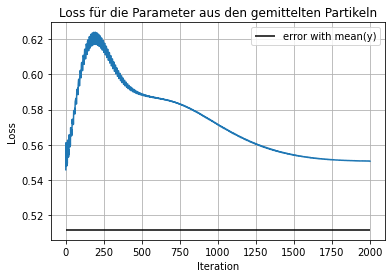

In [29]:
plt.hlines(y = mean_squared_error(y, np.ones(y.shape[0])*np.mean(y)), xmin = 1, xmax = len(loss_evolution)+1, color = "black", label = "error with mean(y)")
plt.plot(np.arange(len(loss_evolution))+1, loss_evolution)
plt.grid()
plt.legend()
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Loss für die Parameter aus den gemittelten Partikeln")
plt.show()

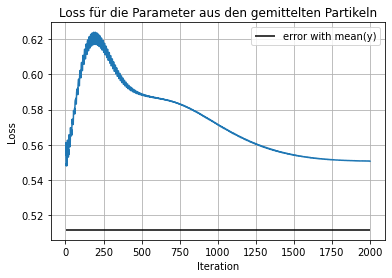

In [30]:
# ohne den initialen Guess
plt.hlines(y = mean_squared_error(y, np.ones(y.shape[0])*np.mean(y)), xmin = 2, xmax = len(loss_evolution)+1, color = "black", label = "error with mean(y)")
plt.plot(np.arange(len(loss_evolution))[1:]+1, loss_evolution[1:])
plt.grid()
plt.legend()
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Loss für die Parameter aus den gemittelten Partikeln")
plt.show()

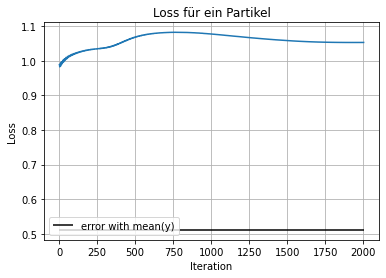

In [31]:
# ohne den initialen Guess
plt.hlines(y = mean_squared_error(y, np.ones(y.shape[0])*np.mean(y)), xmin = 2, xmax = len(loss_evolution)+1, color = "black", label = "error with mean(y)")
plt.plot(np.arange(len(loss_evolution_single_dict["particle_1"]))[1:]+1, loss_evolution_single_dict["particle_1"][1:])
plt.grid()
plt.legend()
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Loss für ein Partikel")
plt.show()

In [32]:
np.sin(np.dot(A, param_mean))

array([ 0.2123402 , -0.01188109,  0.02565378, -0.2373027 ,  0.06329848,
        0.52566414, -0.28799296, -0.62439878,  0.163735  , -0.01037533,
        0.39696543,  0.12536688,  0.16734597,  0.237649  , -0.20857535,
        0.1295385 , -0.13666448,  0.13355222,  0.58471903,  0.11247239,
        0.05546132,  0.58946071, -0.46858767, -0.06577348, -0.02743639,
        0.11736103, -0.30843   ,  0.10048634, -0.01151533,  0.02131066,
        0.20647543,  0.0313241 , -0.03573616,  0.70774915,  0.20528743,
       -0.31225949,  0.19451483, -0.12454861, -0.06516282,  0.0887894 ,
        0.43451768, -0.12456669, -0.09851214, -0.19473564,  0.31243898,
        0.35873321,  0.28397044, -0.24402125, -0.05634942, -0.1713293 ,
        0.06763485, -0.05516346, -0.09469859,  0.10118562,  0.49784044,
       -0.07875319,  0.03124846,  0.29403585,  0.334785  , -0.06649059,
        0.01734733, -0.23511428, -0.45298268, -0.61663842, -0.05567626,
       -0.42400145, -0.34945846,  0.53272984,  0.5043091 ,  0.67

In [33]:
y

array([-0.19288411, -0.86328866,  0.90023766, -0.88022534, -0.46903451,
        0.10435048,  0.31543729,  0.96366562, -0.2525267 , -0.97861517,
        0.73169917, -0.25321707, -0.7256291 ,  0.59877094,  0.85033526,
       -0.22546769,  0.80733883, -0.7129917 ,  0.97704856, -0.8000609 ,
        0.61489522,  0.68328304, -0.67966682,  0.64347089,  0.99125747,
       -0.32404837, -0.66500662,  0.32127323,  0.82732356,  0.9821182 ,
       -0.53970247, -0.26064036, -0.99909676,  0.87786629,  0.67620044,
        0.23908023, -0.73422458,  0.19178662,  0.36503335, -0.04757552,
        0.11302864,  0.23438064, -0.56017968, -0.70056255,  0.31436674,
        0.55875484,  0.97484765, -0.92092234, -0.92630662,  0.98677189,
       -0.98479169,  0.74022779, -0.33124211,  0.73670426, -0.92391445,
       -0.44982514, -0.36551672,  0.94616909, -0.26133971,  0.96878477,
        0.95977447, -0.98168392,  0.72505974, -0.00382282,  0.94131077,
       -0.9575288 ,  0.00793093,  0.91725125, -0.99503823, -0.56

In [34]:
print("Error mit Mittelwert als prediction: {}".format(mean_squared_error(y, np.ones(y.shape[0])*np.mean(y))))
print("Final model error: {}".format(loss_evolution[-1]))

Error mit Mittelwert als prediction: 0.5114195407413349
Final model error: 0.5505944183874122
